## 1.2 Filtered Boston housing and kernels

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import distance
from collections import Counter

In [3]:
# import CSV file
housing = pd.read_csv('Boston-filtered.csv')

#print(housing.head()) # N = 506 

In [4]:
def find_mse(y_true, y_pred):
    """ Compute MSE """
    return np.mean((y_true - y_pred) ** 2)

In [9]:
def linear_regression(X, y, method='pseudo'):
    """Estimate linear regression coefficients using different formulation"""
    
    if method == 'primal': 
        #return np.linalg.inv(X.T @ X) @ (X.T @ y) 
        return np.linalg.solve(X.T @ X, X.T @ y)
    
    elif method == 'pseudo':  
        return np.linalg.pinv(X.T @ X) @ (X.T @ y)

In [5]:
def random_split_data(data, target_variable, test_size=1/3):
    """ Split the data set into 2/3 train, 1/3 test randomly. """
    
    # total sample size
    num_samples = len(data)
    
    # shuffle indices for random split
    indices = np.arange(num_samples)
    np.random.shuffle(indices) 
    
    # calculate test sample size
    test_sample_size = int(num_samples * test_size)
    
    # split indices into train and test 
    train_indices = indices[test_sample_size:]
    test_indices = indices[:test_sample_size]
    
    # split the data into train and test sets 
    data_train = data.iloc[train_indices]
    data_test = data.iloc[test_indices]
    
    # split dataset into features and target variable for train and test
    X_train = data_train.drop(target_variable, axis=1).values  
    y_train = data_train[target_variable].values  
    
    X_test = data_test.drop(target_variable, axis=1).values  
    y_test = data_test[target_variable].values  
    
    return X_train, X_test, y_train, y_test


In [6]:
# 1. Naive Regression (Predicting with the mean y-value on the training set.)
def naive_regression( data, target_variable, n_runs=20):
    mse_train_list = []
    mse_test_list = []

    for _ in range(n_runs):
        # get random splitted dataset
        X_train, X_test, y_train, y_test = random_split_data(data, target_variable)

        # create a vector of ones for both training and testing (constant function)
        X_train_ones = np.ones((X_train.shape[0], 1))  # Adding bias term (a column of ones)
        X_test_ones = np.ones((X_test.shape[0], 1))

        # estimate weights: mean of y_train
        w = linear_regression(X_train_ones, y_train, method = 'primal')
        
        # predict y using the constant function w
        y_train_pred = X_train_ones * w
        y_test_pred = X_test_ones * w

        # calculate MSE for train and test
        mse_train = find_mse(y_train, y_train_pred)
        mse_test = find_mse(y_test, y_test_pred)

        mse_train_list.append(mse_train)
        mse_test_list.append(mse_test)

    # Return the average MSE over the n_runs
    return np.mean(mse_train_list), np.mean(mse_test_list), np.std(mse_train_list), np.std(mse_test_list)


# 2. Linear Regression with Single Attributes (Predicting with a single attribute and a bias term.)
def single_attribute_regression(data, target_variable, n_runs=20):
    mse_train_list = np.zeros((n_runs, data.shape[1] - 1))  # n_runs iterations, 12 attributes
    mse_test_list = np.zeros((n_runs, data.shape[1] - 1))

    for run in range(n_runs):
        # get random splitted dataset
        X_train, X_test, y_train, y_test = random_split_data(data, target_variable)

        # perform linear regression with each attribute and a bias term
        for attr in range(X_train.shape[1]):
            # filter the current attribute 
            X_train_attr = X_train[:, attr].reshape(-1, 1)
            X_test_attr = X_test[:, attr].reshape(-1, 1)

            # add bias term (i.e. a column of ones)
            X_train_attr = np.hstack([X_train_attr, np.ones((X_train_attr.shape[0], 1))])
            X_test_attr = np.hstack([X_test_attr, np.ones((X_test_attr.shape[0], 1))])

            # estimate weights
            w = linear_regression(X_train_attr, y_train, method = 'primal')
            
            # predict y using esimated weights
            y_train_pred = X_train_attr @ w
            y_test_pred = X_test_attr @ w

            # calculate MSE for train and test
            mse_train = find_mse(y_train, y_train_pred)
            mse_test = find_mse(y_test, y_test_pred)

            # save the MSE for the current attribute (across all runs)
            mse_train_list[run, attr] = mse_train
            mse_test_list[run, attr] = mse_test

    # Compute average MSE for each attribute (across 20 runs)
    avg_mse_train = np.mean(mse_train_list, axis=0)
    avg_mse_test = np.mean(mse_test_list, axis=0)
    std_mse_train = np.std(mse_train_list, axis=0)
    std_mse_test = np.std(mse_test_list, axis=0)

    return avg_mse_train, avg_mse_test, std_mse_train, std_mse_test


# 3. Linear Regression using All Attributes and a bias term
def all_attributes_regression(data, target_variable, n_runs=20):
    mse_train_list = []
    mse_test_list = []

    for _ in range(n_runs):
        # get random splitted dataset
        X_train, X_test, y_train, y_test = random_split_data(data, target_variable)

        # add bias term (i.e. a column of ones)
        X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
        X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])

        # estimate weights
        w = linear_regression(X_train, y_train, method = 'primal')

        # predict y using esimated weights
        y_train_pred = X_train @ w
        y_test_pred = X_test @ w

        # calculate MSE for train and test
        mse_train = find_mse(y_train, y_train_pred)
        mse_test = find_mse(y_test, y_test_pred)
        
        mse_train_list.append(mse_train)
        mse_test_list.append(mse_test)

    return np.mean(mse_train_list), np.mean(mse_test_list), np.std(mse_train_list), np.std(mse_test_list)


In [10]:
def run_all_methods(data, target_variable, n_runs=20, add_plot = False):
    """ run all 3 regression methods, report and plot MSE """
    # Get MSE from each method
    avg_mse_train_naive, avg_mse_test_naive, std_mse_train_naive, std_mse_test_naive = naive_regression(data, target_variable, n_runs)
    avg_mse_train_single, avg_mse_test_single, std_mse_train_single, std_mse_test_single = single_attribute_regression(data, target_variable, n_runs)
    avg_mse_train_all, avg_mse_test_all, std_mse_train_all, std_mse_test_all = all_attributes_regression(data, target_variable, n_runs)

    # Print average MSE for each method
    print(f"{n_runs} Runs are Implemented for Each Regression Method")
    
    print("--------------------------------------------------")
    print(f"Naive Regression - Average Train MSE: {avg_mse_train_naive}, Test MSE: {avg_mse_test_naive}" )
    print(f"Naive Regression - Standard Deviation Train MSE: {std_mse_train_naive}, Test MSE: {std_mse_test_naive}" )
    
    print("--------------------------------------------------")
    print(f"Single Attribute Regression - Average Train MSE: {avg_mse_train_single}, Test MSE: {avg_mse_test_single}")
    print(f"Single Attribute Regression - Standard Deviation Train MSE: {std_mse_train_single}, Test MSE: {std_mse_test_single}" )
    
    print("--------------------------------------------------")
    print(f"All Attributes Regression - Average Train MSE: {avg_mse_train_all}, Test MSE: {avg_mse_test_all}")
    print(f"All Attribute Regression - Standard Deviation Train MSE: {std_mse_train_all}, Test MSE: {std_mse_test_all}" )
    
    if add_plot:
        # get 12 attribute names from the data
        attribute_names = data.columns[:12].tolist()  
        
        # Plotting
        fig, ax = plt.subplots(figsize=(12, 6))

        # Bar positions
        x_naive = np.array([0])
        x_single = np.arange(1, len(avg_mse_train_single) + 1)  
        x_all = np.array([len(avg_mse_train_single) + 1]) 
        
        # Bar widths
        width = 0.35
        
        # plot for Naive regression
        ax.bar(x_naive - width / 2, [avg_mse_train_naive], width, color='lightblue')
        ax.bar(x_naive + width / 2, [avg_mse_test_naive], width, color='orange')
        
        # plot for Single attribute regression
        ax.bar(x_single - width / 2, avg_mse_train_single, width, label='Train', color='lightblue')
        ax.bar(x_single + width / 2, avg_mse_test_single, width, label='Test', color='orange')
        
        # plot for All attributes regression
        ax.bar(x_all - width / 2, [avg_mse_train_all], width, color='lightblue')
        ax.bar(x_all + width / 2, [avg_mse_test_all], width, color='orange')
        
        # add labels and title
        ax.set_xlabel('Regression Methods / Attributes')
        ax.set_ylabel(f'Average MSE acrros {n_runs} Runs')
        ax.set_title('Comparison of MSE for Different Regression Methods')
        ax.set_xticks(np.concatenate([x_naive, x_single, x_all]))
        ax.set_xticklabels(['Naive'] + attribute_names + ['All Attributes'])
        
        ax.legend()
        plt.tight_layout()
        plt.show()



20 Runs are Implemented for Each Regression Method
--------------------------------------------------
Naive Regression - Average Train MSE: 83.21579493014949, Test MSE: 87.03003822707788
Naive Regression - Standard Deviation Train MSE: 4.390263249341362, Test MSE: 8.928185778474504
--------------------------------------------------
Single Attribute Regression - Average Train MSE: [72.78124998 74.05685176 65.2958193  82.75677146 69.73240774 43.06756102
 73.4318456  80.0860769  72.56118406 66.33674409 63.28441387 38.81895645], Test MSE: [70.34342727 72.83306796 63.8844838  80.54002349 67.96702703 45.0663517
 70.93504054 77.79106413 71.84046715 65.53034604 61.92430679 38.12615768]
Single Attribute Regression - Standard Deviation Train MSE: [4.85566821 5.15145884 4.89819025 4.75861234 4.90302101 2.718243
 5.26262943 5.46934063 5.11230429 4.82557536 4.07781383 2.51661411], Test MSE: [ 9.70568617 10.48744807 10.10723313  9.54971158  9.99148516  5.6332171
 10.80784069 11.25261326 10.52070374 

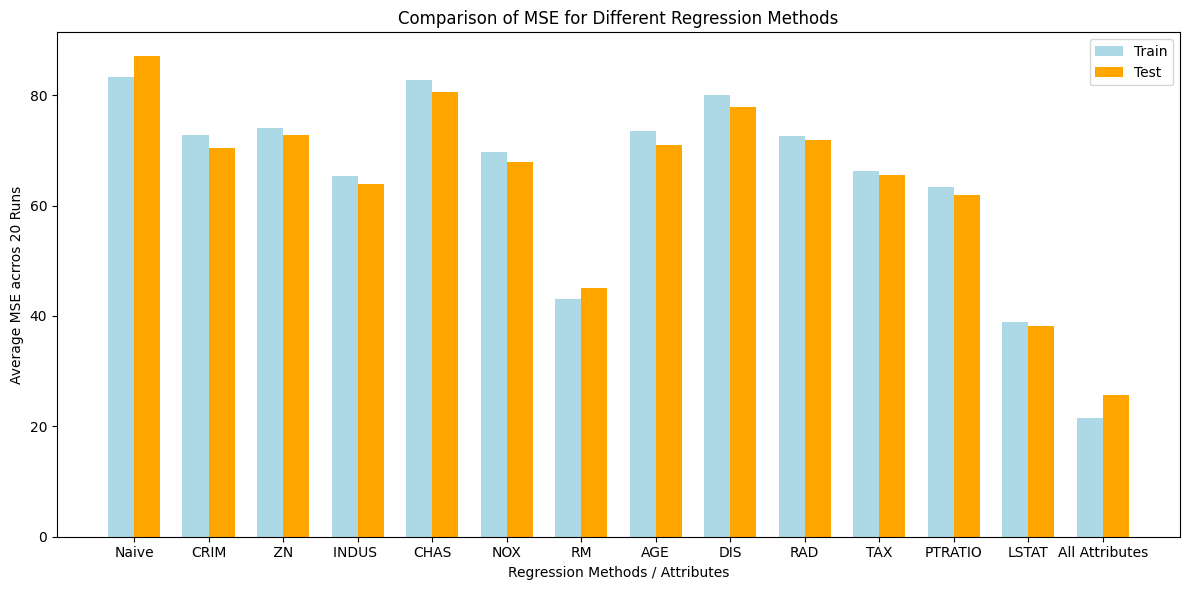

In [11]:
# Run all 3 methods with 20 different random splits and plot
run_all_methods(housing, 'MEDV' , n_runs=20, add_plot = True)